# Preliminary analysis of CDC pilot project

In [1]:
import pandas as pd
from ete3 import NCBITaxa
import os
import seaborn
import matplotlib.pyplot as plt
import math

Download NCBI taxonomy database: 

In [2]:
ncbi = NCBITaxa()
#ncbi.update_taxonomy_database()

Download table from IDseq containing number of reads mapping to each species.

In [4]:
report_dir = "../../data/MOS002_reports"
sample_table_csv = "../../data/MOS002_sample-table.csv"

In [5]:
sample_table = pd.read_csv(sample_table_csv)

## Reports

In [45]:
report_csv = report_dir+"/"+sample_table.sample_name+"_report.csv"
reports = pd.concat([pd.read_csv(x).assign(sample_name=os.path.basename(x).replace("_report.csv", "")) for x in report_csv])
reports = pd.merge(reports, sample_table[['sample_name', 'total_reads', 'nonhost_reads', 'nonhost_reads_percent', 'ercc_reads', 'tissue_type', 'location', 'notes', 'sample_diagnosis']], how='left', on='sample_name')

/Users/lucy.li/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


In [57]:
bloodmeal_top_perc_id = reports[(reports.category_name=="Eukaryota") & (reports.tax_level==2)].groupby(['sample_name']).head(5).groupby(['sample_name']).agg({'NR_percentidentity':'max'}).rename({'NR_percentidentity':'max_NR_percentidentity'}, axis='columns')
bloodmeal_df = pd.merge(reports, bloodmeal_top_perc_id, how='left', on=['sample_name'])
bloodmeal_df = bloodmeal_df[bloodmeal_df['NR_percentidentity']==bloodmeal_df['max_NR_percentidentity']].groupby(['sample_name']).head(1)[['sample_name', 'name', 'common_name', 'tax_id', 'location', 'notes', 'sample_diagnosis']]
bloodmeal_df.to_csv("../../data/MOS002_sample_table_bloodmeal_calls.csv")


In [48]:
reports_viruses = reports[(reports.category_name=="Viruses") & (reports.tax_level==2)]

In [49]:
NT_r_family = reports_viruses.groupby(['sample_name', 'family_taxid'])['NT_r'].sum().to_frame()
NT_r_family = NT_r_family.reset_index(level=0).reset_index(level=0)
family_dict = ncbi.get_taxid_translator(NT_r_family.family_taxid.tolist())
NT_r_family['family_name'] = NT_r_family.family_taxid.apply(lambda x: family_dict[x] if x>0 else 'unassigned Mononegavirales')
for x in sample_table.sample_name:
    if (not NT_r_family.sample_name.str.contains(x).any()):
        dict_to_add = {'family_taxid': "none found", 'sample_name': x, 'NT_r': 0.0, 'family_name': "none found"}
        NT_r_family = NT_r_family.append(dict_to_add, ignore_index=True)
NT_r_family.sort_values(by='sample_name', axis=0, inplace=True)
NT_r_family = NT_r_family[['sample_name', 'family_name', 'NT_r']].groupby(['sample_name', 'family_name'])['NT_r'].sum().to_frame().reset_index(level=0).reset_index(level=0)

In [50]:
NT_r_family.head()

,family_name,sample_name,NT_r
0,Herpesviridae,MOS002-01a-hom-R1,0.0
1,Rhabdoviridae,MOS002-01a-hom-R1,2.0
2,none found,MOS002-02a-hom-R1,0.0
3,none found,MOS002-03a-hom-R1,0.0
4,Herpesviridae,MOS002-04a-hom-R1,0.0


## Plotting heatmap of viruses

In [51]:
def plot_heatmap (df, title='', vmin=math.log10(0.00000001), vmax=math.log10(NT_r_family.NT_r.max())):
    df = pd.pivot_table(df, values='NT_r', index=['sample_name'], columns=["family_name"]).fillna(0)
    df = df.applymap(lambda x: math.log10(x+0.00000001))
    if ('none found' in df.columns):
        df = df.drop('none found', axis=1)
    seaborn.set(style="whitegrid", font_scale=2)
    ax = seaborn.heatmap(data=df, vmin=vmin, vmax=vmax, cmap="RdPu", xticklabels=True, yticklabels=True)
    ax.set_title(title)


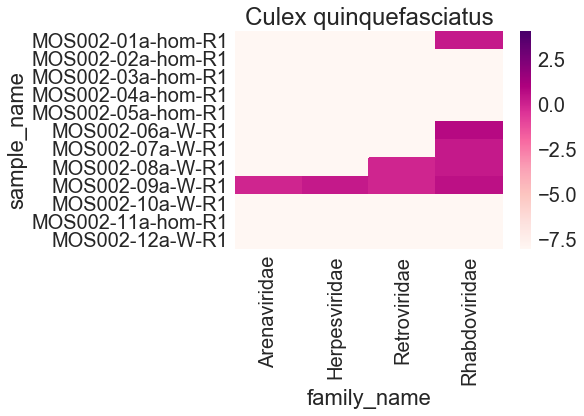

In [52]:
culex_quing_virus_df = NT_r_family[:NT_r_family.loc[NT_r_family.sample_name.str.contains('13a')].index[0]]
plot_heatmap (culex_quing_virus_df, title="Culex quinquefasciatus")

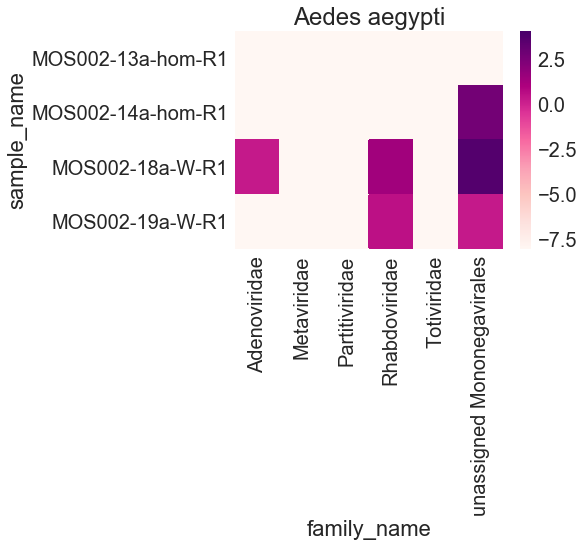

In [53]:
aedes_aegypti_virus_df = NT_r_family.loc[NT_r_family.sample_name.str.contains('1[3-48-9]a', regex=True)]
plot_heatmap (aedes_aegypti_virus_df, title="Aedes aegypti")

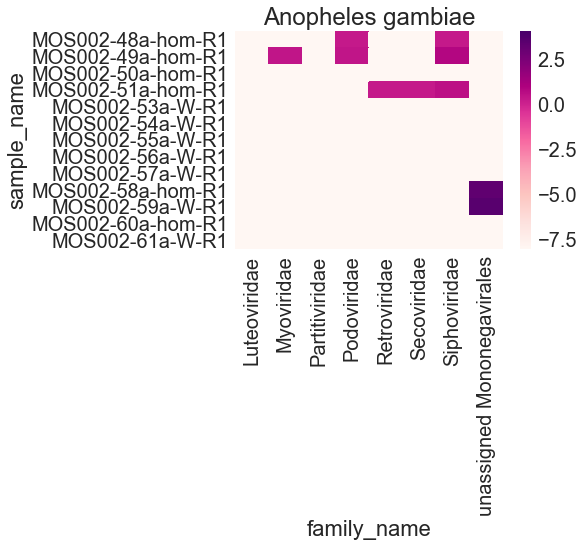

In [54]:
anopheles_gambiae_virus_df = NT_r_family.loc[NT_r_family.sample_name.str.contains('4[8-9]a|5[0-1|3-9]a|6[0|1]a', regex=True)]
anopheles_gambiae_virus_df
plot_heatmap (anopheles_gambiae_virus_df, title="Anopheles gambiae")


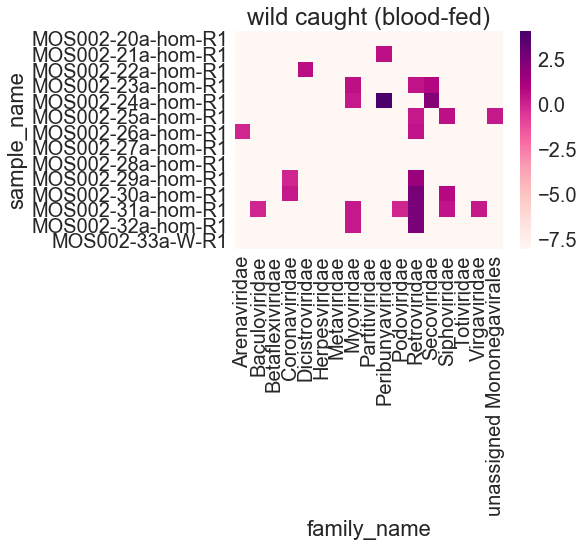

In [55]:
wild_bloodfed_df = NT_r_family.loc[NT_r_family.sample_name.str.contains('2[0-9]a|3[0-3]a', regex=True)]
plot_heatmap (wild_bloodfed_df, title="wild caught (blood-fed)")

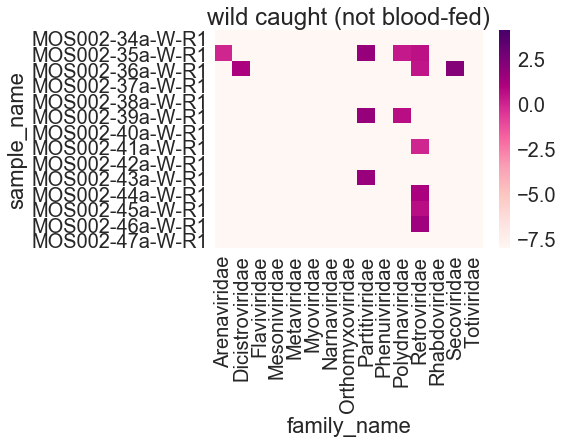

In [56]:
wild_nonbloodfed_df = NT_r_family.loc[NT_r_family.sample_name.str.contains('3[4-9]a|4[0-7]a', regex=True)]
plot_heatmap (wild_nonbloodfed_df, title="wild caught (not blood-fed)")